# PA005: High Value Customer Identification (Insiders)

# Ciclo 0 -  Planejamento da solução (IOT)

# Ciclo 1 -  Métricas de Validação de Clusters

1. Feature Engineering
* Recency
* Frequency
* Monetary

2. Métricas de Validação de clusters
* WSS - (Within-Cluster Sum of Squares)
* SS - (Silhouette Score)

3. Cluster Analisys
* Plot 3d
* Cluster profile

# Ciclo 2 - Análise de Silhouette

1. Feature Engineering
* Average Ticket


2. Análise de Silhouette
* Silhouette Analysis


3. Clustering visualization
* UMAP


4. Cluster análise de perfil
* Descrição dos centroides dos clusters

# Ciclo 3 - Statistical Descriptive

1. Análise Descritiva
* Atributos Numéricos
* Atributos Categóricos

2. Data Filtering
* Retornos e Compras

3. Feature Engineering
* Utilização dos dados de compra
* Average Recency
* Number of returns



## Input - Entrada

1. Problema de negócio

    --Selecionar os clientes mais valiosos para integrar um programa de fidelização
    
2. Conjunto de dados

    --Vendas de um e-commerce, durante um período de um ano

## Output - Saída

1. A idicação de clientes que farão parte do programa de Insiders

    --Lista: client_id | is_insider
            455534     | yes
            433524     | no
            
2. Relatório com as respostas das perguntas de negócios

    2.0. Quem são as pessoas elegíveis para fazer parte do grupo de Insiders?

    2.1. Quantos clientes farão parte do grupo?
    
    2.2. Quais as principais características desses clientes?
    
    2.3. Qual a porcentagem de contribuição do faturamento vindo dos Insiders?
    
    2.4. Qual a expectativa de faturamento desse grupo para os próximos meses?
    
    2.5. Quais as condições para umma pessoa ser elegível ao Insiders?
    
    2.6. Quais as condições para umma pessoa ser removida do Insiders?
    
    2.7. Qual a garantia que o programa Insiders é melhor que o restante da base?
    
    2.8. Quais ações o time de marketing pode realizar para aumentar o faturamento?
    
    

## Tasks - Tarefas

    0. Quem são as pessoas elegíveis para fazer parte do grupo de Insiders?  
        - O que são clientes de maior "valor"?
        - Faturamento
            - Alto ticket médio
            - Alto LTV
            - Baixa recência
            - Baixa probabilidade de churn
            - Alto basket size
            - Alta previsão LTV
            - Alta propensão de compra
            
        - Custo
            - Baixa taxa de devolução
            
        - Experiência de compra
            - Média alta das avaliações
    
    1. Quantos clientes farão parte do grupo?
        - Número total de clientes
        - % do grupo de Insiders
    
    2. Quais as principais características desses clientes?
        -Características dos clientes:
            - Idade
            - Localização
            
        - Características de consumo:
            - Atributos da clusterização
        
    
    3. Qual a porcentagem de contribuição do faturamento vindo dos Insiders?
            - Faturamento do ano
            - Faturamento dos Insiders
    
    4. Qual a expectativa de faturamento desse grupo para os próximos meses?
            - LTV do grupo Insiders
            - Análise de Cohort
    
    5. Quais as condições para umma pessoa ser elegível ao Insiders?
            - Definir periodicidade
            - A pessoa precisa ser similar ou parecido com uma pessoa do grupo
            
    6. Quais as condições para umma pessoa ser removida do Insiders?
            - Definir periodicidade
            - A pessoa precisa ser dissimilar ou parecido com uma pessoa do grupo
            
    7. Qual a garantia que o programa Insiders é melhor que o restante da base?
            - Teste A/B
            - Teste A/B Bayesiano
            - Teste de hipóteses
    
    8. Quais ações o time de marketing pode realizar para aumentar o faturamento?
            - Desconto
            - Preferência de compra
            - Frente
            - Visita a empresa

## Benchmark de soluções

### 1. Desk research

Modelo RFM
1. Recency
    a) Tempo desde a última compra
    b) Responsividade

2. Frequency
    a) Tempo médio entre as transações
    b) Engajamento
    
3. Monetary 
    a) Total gasto, faturamento
    b) 'High-value purchases'

# 0.0. Imports

In [1]:

from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer

from matplotlib  import pyplot        as plt
from sklearn     import cluster       as c
from sklearn     import metrics       as m
from sklearn     import preprocessing as pp
from plotly      import express       as px

import pandas as pd
import seaborn as sns
import numpy as np

import re

In [2]:
import umap.umap_ as umap


/home/heitor/repos/insiders_clustering/venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0.2. Helper Functions

In [3]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)

def num_attributes(df1):
    
    num_attributes = df1.select_dtypes(['int64', 'float64'])

    #central tendency
    ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

    #dispersion
    d1 = pd.DataFrame(num_attributes.apply(np.min)).T
    d2 = pd.DataFrame(num_attributes.apply(np.max)).T
    d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
    d4 = pd.DataFrame(num_attributes.apply(np.std)).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

    m = pd.concat( [d1, d2, d3, ct1, ct2, d4, d5, d6] ).T.reset_index()
    m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis']
    return m

## 0.3. Load Data

In [4]:
df_raw = pd.read_csv(r'../data/Ecommerce.csv')


# 1.0. Data Description

In [5]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [6]:
df1.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [7]:
df1.columns = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date',
       'unit_price', 'customer_id', 'country']

## 1.2. Data Shape

In [8]:
print(f'Number of rows: {df1.shape[0]}')
print(f'Number of columns: {df1.shape[1]}')

Number of rows: 541909
Number of columns: 8


## 1.3. Data Types

In [9]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4. Check NAs


In [10]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5. Fill NAs

In [11]:
#remove na
df1 = df1.dropna(axis=0)

print('Data removed: {:.0f}%'.format((1-(len(df1)/len(df_raw)))*100))

Data removed: 25%


## 1.6. Change dtypes

In [12]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

In [13]:
#invoice_no 
# df1['invoice_no'] = df1['invoice_no'].astype(int)


#stock_code 
# df1['stock_code'] = df1['stock_code'].astype(int)


#invoice_date  --> Month --> b
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format=('%d-%b-%y'))


#customer_id
df1['customer_id'] = df1['customer_id'].astype(int)
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
customer_id              int64
country                 object
dtype: object

## 1.7. Descriptive statistics

In [14]:
num_attributes = df1.select_dtypes(['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [15]:
m = num_attributes(df1)
m

TypeError: 'DataFrame' object is not callable

#### 1.7.1.1 Investigating

1. Negative quantity (devolution?)
2. Price = 0 (Promo?)

## 1.7.2. Categorical Attributes

In [ ]:
cat_attributes.head()

#### Invoice no

In [ ]:

#invoice_no -- some of them has one char
df_invoice_char = df1.loc[df1['invoice_no'].apply(lambda x: bool(re.search('[^0-9]+', x))), :]   

len(df_invoice_char[df_invoice_char['quantity']<0])


print('Total of invoices with letter: {}'.format(len(df_invoice_char)))
print('Total of negative quantaty: {}'.format(len(df1[df1['quantity']<0])))
print('Letter means negative quantity')

#### Stock Code

In [ ]:
#all stock codes with char
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

#remove stock code in ['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK']
# df1 = df1[-df1.isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]

#### Description

In [ ]:
#remove description
# df1 = df1.drop('description', axis=1)

#### Country


In [ ]:
df1['country'].value_counts(normalize='True').head()

In [ ]:
df1[['country', 'customer_id']].drop_duplicates().groupby('country').count().reset_index().sort_values('customer_id', ascending=False).head()

# 2.0. Data Filtering

In [16]:
df2 = df1.copy()

In [22]:
df2['country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Greece', 'Singapore', 'Lebanon',
       'United Arab Emirates', 'Saudi Arabia', 'Czech Republic', 'Canada',
       nan, 'Brazil', 'USA', 'Bahrain', 'Malta', 'RSA'], dtype=object)

In [21]:
# ====================== Numerical Attributes ====================== 

#unit price != 0
# df2.sort_values('unit_price').head()
df2 = df2[df2['unit_price']>0.004]

# ====================== Categorical Attributes ====================== 

#stock code
df2 = df2[~df2.isin(['POST', 'D', 'M', 'PADS', 'DOT', 'CRUK'])]

#description
df2 = df2.drop('description', axis=1)


#map
df2 = df2[~df2.isin(['European Community', 'Unspecified'])]

# #quantity - negative numbers mean return
df_return = df2[df2['quantity']<0]
df_purchase = df2[df2['quantity']>0]




# 3.0. Feature Engineering

In [33]:
df3 = df2.copy()

## 3.1. Feature Creation

In [34]:
# df_purchase.loc[:, 'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price']  
df_purchase.loc[:,'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price'] 

#data reference
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date',
       'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)


df_monetary = df_purchase.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').sum().reset_index()
df_ref = pd.merge(df_ref, df_monetary, on='customer_id', how= 'left')
df_ref.isna().sum()

/tmp/ipykernel_19796/959218557.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_purchase.loc[:,'gross_revenue'] = df_purchase.loc[:, 'quantity'] * df_purchase.loc[:, 'unit_price']


customer_id       0
gross_revenue    33
dtype: int64

In [35]:
#recency --> max date

df_recency = df_purchase.loc[:,['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = (df3['invoice_date'].max() - df_recency['invoice_date']).dt.days
df_recency  = df_recency[['customer_id', 'recency_days']].copy()
df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

#frequency
df_freq = df_purchase.loc[:,['customer_id', 'invoice_no']].drop_duplicates().groupby('customer_id').count().reset_index()
df_ref = pd.merge(df_ref, df_freq, on='customer_id', how='left')


#avg ticket
df_avgticket = df_purchase.loc[:,['customer_id', 'gross_revenue']].groupby('customer_id').mean().rename(columns={'gross_revenue':'avg_ticket'}).reset_index()
df_ref = pd.merge(df_ref, df_avgticket, on='customer_id', how='left')







In [36]:
df_ref.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,5391.21,372.00,34.00,18.15
1,13047,3237.54,31.00,10.00,18.82
2,12583,7281.38,2.00,15.00,29.48
3,13748,948.25,95.00,5.00,33.87
4,15100,876.00,333.00,3.00,292.00


# 4.0. Exploratory Data Analisys

In [42]:
df4 = df_ref.dropna().copy()

# 5.0. Data Preparation

In [57]:
df5 = df4.copy()

ss = pp.StandardScaler()
mms = pp.MinMaxScaler()

In [59]:
df5['gross_revenue'] = ss.fit_transform(df5[['gross_revenue']])
df5['recency_days'] = ss.fit_transform(df5[['recency_days']])
df5['invoice_no'] = ss.fit_transform(df5[['invoice_no']])
df5['avg_ticket'] = ss.fit_transform(df5[['avg_ticket']])

In [64]:
df5.head()

,customer_id,gross_revenue,recency_days,invoice_no,avg_ticket
0,17850,0.37,2.80,3.86,-0.03
1,13047,0.13,-0.61,0.74,-0.03
2,12583,0.58,-0.90,1.39,-0.03
3,13748,-0.12,0.03,0.09,-0.02
4,15100,-0.13,2.41,-0.17,0.15


# 6.0. Feature Selection

In [60]:
df6 = df5.copy()

# 7.0. Hyperparameter Fine-Tunning

In [61]:
X = df6.drop('customer_id', axis=1)
clusters = [2,3,4,5,6]

## 7.1. Within-Cluster Sum of Squares (WSS)

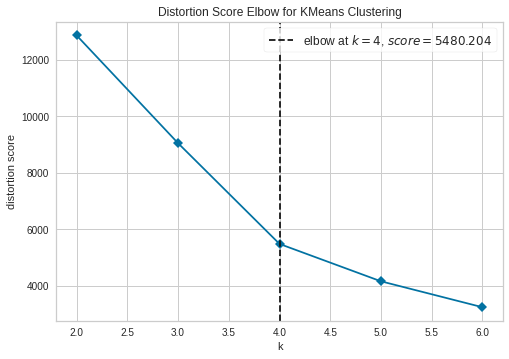

In [62]:
#Easy way

kmeans = KElbowVisualizer(c.KMeans(), k=clusters, timings=False)
kmeans.fit(X)
kmeans.show();



## 7.2. Silhouette Score

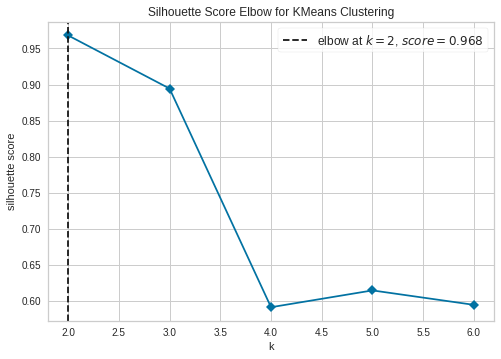

In [63]:
#Easy way
kmeans = KElbowVisualizer(c.KMeans(), k=clusters, metric = 'silhouette', timings = False)
kmeans.fit(X)
kmeans.show();

# 8.0. Model Training

## 8.1. KMeans

In [65]:
#model definition
k = 3
kmeans = c.KMeans(init='random', n_clusters=k, n_init=10, max_iter=300, random_state=3)

#model training
kmeans.fit(X)

#clustering
labels = kmeans.labels_

# 9.0. Cluster Analisys

In [66]:
df9 = df6.copy()
df9['cluster'] = labels


## 9.1. Visualization Inspection

/home/heitor/repos/insiders_clustering/venv/lib/python3.8/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


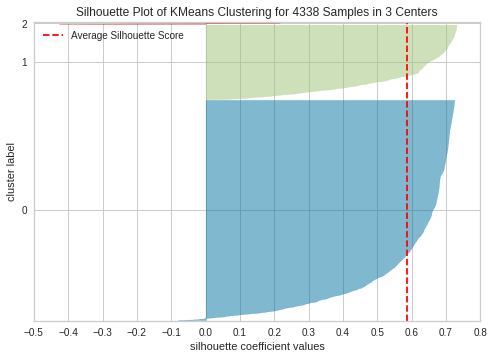

In [67]:


visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

## 9.2. 2d Plot

In [68]:
# df_vis = df9.drop('customer_id', axis=1)
# sns.pairplot(df_vis, hue='cluster')



## 9.3. UMAP t-SNE

<AxesSubplot:xlabel='embedding_x', ylabel='embedding_y'>

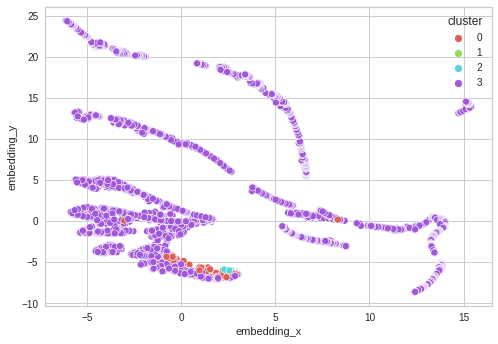

In [69]:
reducer = umap.UMAP(n_neighbors=30, random_state=3)
embedding = reducer.fit_transform(X)

df_vis['embedding_x'] = embedding[:,0]
df_vis['embedding_y'] = embedding[:,1]
sns.scatterplot(x='embedding_x', y='embedding_y', hue='cluster',
              palette = sns.color_palette('hls', n_colors = len(df_vis['cluster'].unique())),
               data = df_vis)

## 9.1. Visualization Inspection

In [70]:
#WSS
print('WSS: {}'.format(kmeans.inertia_))

#SS
print('SS: {}'.format(m.silhouette_score(X,labels, metric='euclidean')))

WSS: 9429.573769591378
SS: 0.5879176205734721


In [ ]:
px.scatter_3d(df9, x='recency_days', y='invoice_no', z='gross_revenue', color='cluster')

## 9.2. Cluster Profile

In [ ]:
aux1 = df9.groupby('cluster').mean().reset_index()

aux1 = aux1.drop('customer_id', axis=1)
aux2 = df9[['customer_id', 'cluster']].groupby('cluster').count().reset_index()

df_cluster = pd.merge(aux1, aux2, on='cluster', how='left')


In [ ]:
df_cluster['perc'] = 100*df_cluster['customer_id']/df_cluster['customer_id'].sum()

df_cluster

## Cluster 0 (insiders)

* Número de clientes: 6
* Percentual de clientes: 0,01%
* Faturamento médio: $182182
* Recência: 7 dias
* Frequência: 89 compras

## Cluster 1 (Hibernating)

* Número de clientes: 4335
* Percentual de clientes: 99%
* Faturamento: $1372
* Recência: 92 dias
* Frequência: 4 compras

## Cluster 2 (potenciais clientes fieis)

* Número de clientes: 31
* Percentual de clientes: 0,07%
* Faturamento: $40543
* Recência: 13 dias
* Frequência: 53 compras




# 10.0. Deploy to Production